In [175]:
import pandas as pd
import numpy as np
import pandas_profiling
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# Problem statement

Given company’s past purchases of plywood, sheetrock, steel beams, rebar, and glass contracts over the past ten years in csv format, can I predict prices 6 months out.

# Data import and exploration

In [176]:
data = pd.read_csv('construction_material_prices_2008_2018.csv')

In [177]:
data.head()

Unnamed: 0  price_steel  price_rebar  price_glass  price_concrete  \
0  2007-01-01          NaN          NaN          NaN             NaN   
1  2007-01-03          NaN          NaN          NaN             NaN   
2  2007-01-04          NaN          NaN          NaN             NaN   
3  2007-01-05          NaN          NaN          NaN             NaN   
4  2007-01-08          NaN          NaN          NaN             NaN   

   price_plywood  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN

In [178]:
data = data.rename(columns={'Unnamed: 0':'date'})
data['date']=pd.to_datetime(data['date'])
data = data.sort_values('date')

In [179]:
data.head(10)

date  price_steel  price_rebar  price_glass  price_concrete  \
0 2007-01-01          NaN          NaN          NaN             NaN   
1 2007-01-03          NaN          NaN          NaN             NaN   
2 2007-01-04          NaN          NaN          NaN             NaN   
3 2007-01-05          NaN          NaN          NaN             NaN   
4 2007-01-08          NaN          NaN          NaN             NaN   
5 2007-01-09          NaN          NaN          NaN             NaN   
6 2007-01-10          NaN          NaN          NaN             NaN   
7 2007-01-11          NaN          NaN          NaN             NaN   
8 2007-01-12          NaN          NaN          NaN             NaN   
9 2007-01-16          NaN          NaN          NaN             NaN   

   price_plywood  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
5            NaN  
6            NaN  
7            NaN  
8            NaN  
9            NaN

In [180]:
data.tail(10)

date  price_steel  price_rebar  price_glass  price_concrete  \
2935 2018-06-06          NaN          NaN          NaN             NaN   
2936 2018-06-07          NaN          NaN          NaN             NaN   
2937 2018-06-08          NaN          NaN          NaN             NaN   
2938 2018-06-11          NaN          NaN          NaN             NaN   
2939 2018-06-12          NaN          NaN          NaN             NaN   
2940 2018-06-13          NaN          NaN          NaN             NaN   
2941 2018-06-14          NaN          NaN          NaN             NaN   
2942 2018-06-15          NaN          NaN          NaN             NaN   
2943 2018-06-18          NaN          NaN          NaN             NaN   
2944 2018-06-19          NaN          NaN          NaN             NaN   

      price_plywood  
2935            NaN  
2936            NaN  
2937            NaN  
2938            NaN  
2939            NaN  
2940            NaN  
2941            NaN  
2942            NaN  
2943            NaN  
2944            NaN

In [181]:
data.isnull().sum()/len(data)*100

date               0.000000
price_steel       21.595925
price_rebar       44.006791
price_glass       50.016978
price_concrete    50.865874
price_plywood      9.235993
dtype: float64

- First several and last several rows are completely missing. 
- Maybe lots of missing rows in between as well, especially for rebar, glass, and concrete.


let's plot out the trends for each commodity

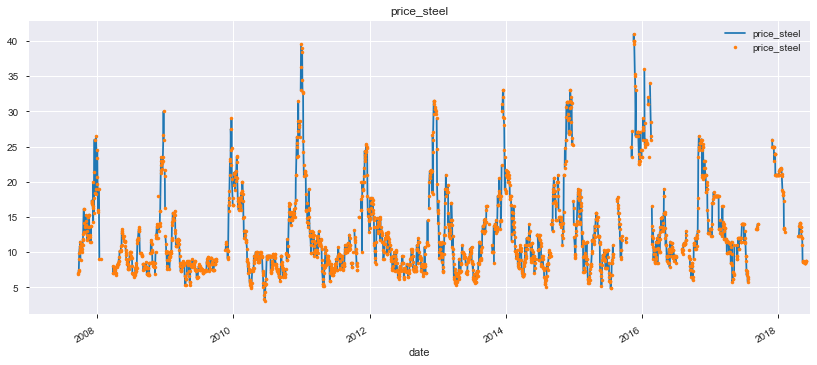

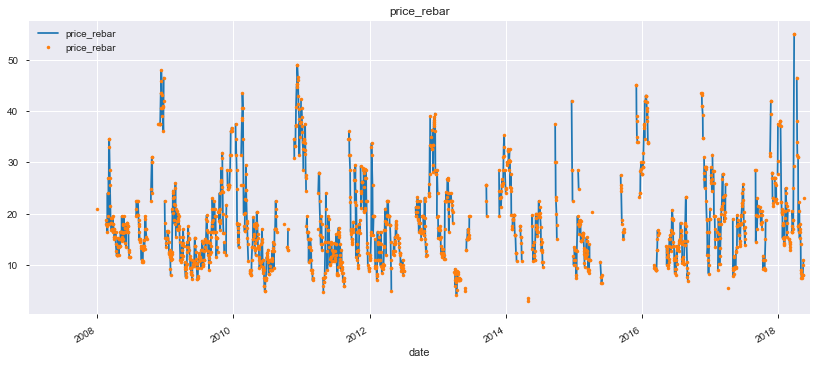

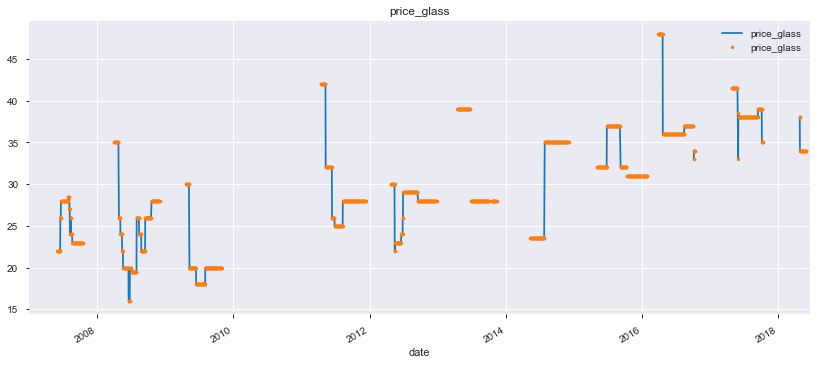

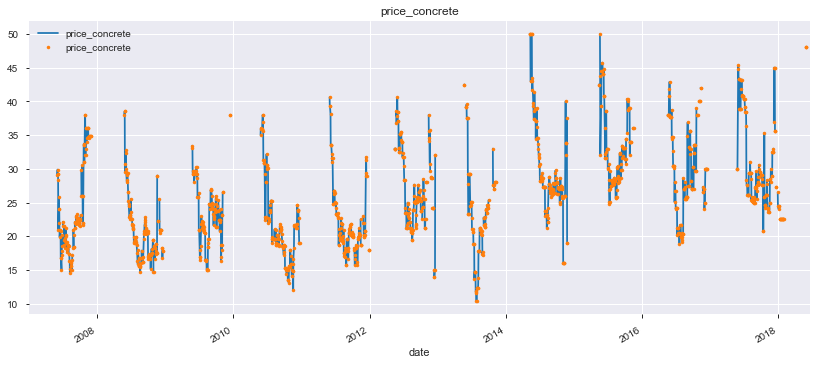

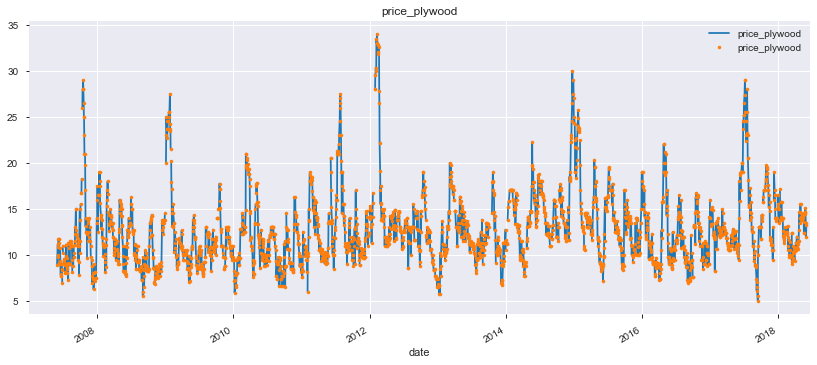

In [182]:
for c in data.columns[1:]:
    ax = data.plot(x='date',y=c,figsize=(14,6),title=c)
    data.plot(x='date',y=c,figsize=(14,6),title=c,style='.',ax=ax)
    

## Initial takeaways

- Steel and rebar both seem to have a 6-month seasonality. No obvious trend is seen in either. Maybe they are correlated since they are the same material.
- glass is missing lots of data and hard to say anything about seasonality but it does maybe have an upward trend.
- concreate is also missing a lot of data and possibly has a slight upward trend. Seasonality is hard to say. Maybe box plots of the data accumulated by month will be more clear.
- plywood has the least missing data but seems a lot more noisy. There's possibly a monthly oscillation but there's also large spikes that look random.

## Correlation Plot

Let's generate the pairplot to look for correlations. 

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning:

invalid value encountered in greater_equal

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning:

invalid value encountered in less_equal



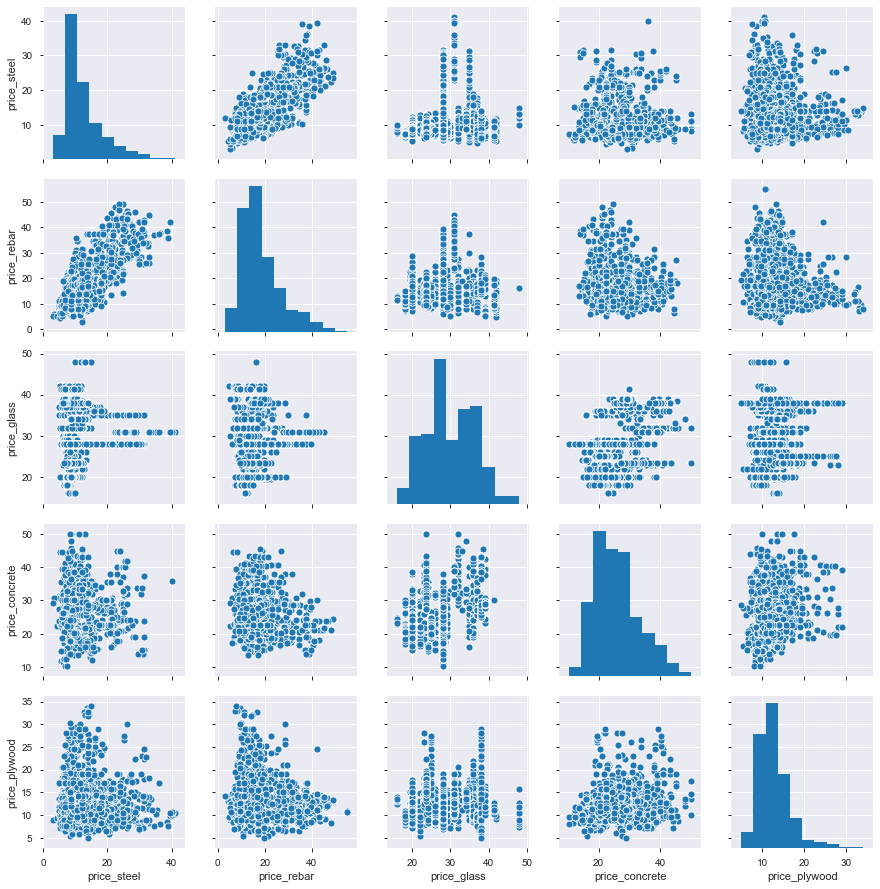

In [183]:
sns.pairplot(data)

There's a definite correlation between rebar and steel. This might be useful for model building later on if we can train off multivariate data (definitely doable for neural net LSTM, not sure about SARIMAX).

Before plotting aggregate box plots (ie. month, week, day of week), let's fill in the missing day timestamps and interpolate.

# Interpolating missing data

We need to interpolate the missing data and get to a continueous time series for each where every day has a datapoint

I can imagine this working in two ways:

1. We decide on a scheme to generate data for every missing day by generating a continueous time axis and akima interpolating.
2. We aggregate to a coaser time scale such as the mean each week and hope then maybe fill in missing week data with above method

The first method is straightforward with pandas interpolate() method and the 2nd method can then be done later on this data. 

But first we need to generate new datetime points for days that are completely skipped in the data currently so our timeseries is continuous.

To do this I will break apart the data by commodity, drop the nan, join to a continues date_range, and interpolate the new missing points.

In [184]:
plywood_df = data[['date','price_plywood']].dropna()
steel_df = data[['date','price_steel']].dropna()
rebar_df = data[['date','price_rebar']].dropna()
glass_df = data[['date','price_glass']].dropna()
concrete_df = data[['date','price_concrete']].dropna()

In [185]:
def fill_days(df):
    date_range = pd.date_range(start=df.date.min(),end=df.date.max())
    new_date_df = pd.DataFrame({'new_date': date_range})
    merged =  pd.merge(new_date_df, df,
                       left_on='new_date', 
                       right_on='date',
                       how='left'
                      )
    return merged.drop(columns=['date'])

In [186]:
plywood_df = fill_days(plywood_df)
plywood_df.head(10)

new_date  price_plywood
0 2007-06-01       8.875000
1 2007-06-02            NaN
2 2007-06-03            NaN
3 2007-06-04      10.833333
4 2007-06-05      11.166667
5 2007-06-06       9.750000
6 2007-06-07      10.000000
7 2007-06-08      11.750000
8 2007-06-09            NaN
9 2007-06-10            NaN

In [187]:
steel_df = fill_days(steel_df)
steel_df.head(10)

new_date  price_steel
0 2007-09-21     6.833333
1 2007-09-22          NaN
2 2007-09-23          NaN
3 2007-09-24     7.000000
4 2007-09-25     7.375000
5 2007-09-26     7.500000
6 2007-09-27     9.000000
7 2007-09-28     9.916667
8 2007-09-29          NaN
9 2007-09-30          NaN

In [188]:
rebar_df = fill_days(rebar_df)
rebar_df.head(10)

new_date  price_rebar
0 2008-01-03         21.0
1 2008-01-04          NaN
2 2008-01-05          NaN
3 2008-01-06          NaN
4 2008-01-07          NaN
5 2008-01-08          NaN
6 2008-01-09          NaN
7 2008-01-10          NaN
8 2008-01-11          NaN
9 2008-01-12          NaN

In [189]:
glass_df = fill_days(glass_df)
glass_df.head(10)

new_date  price_glass
0 2007-06-01         22.0
1 2007-06-02          NaN
2 2007-06-03          NaN
3 2007-06-04         22.0
4 2007-06-05         22.0
5 2007-06-06         22.0
6 2007-06-07         22.0
7 2007-06-08         22.0
8 2007-06-09          NaN
9 2007-06-10          NaN

In [190]:
concrete_df = fill_days(concrete_df)
concrete_df.head(10)

new_date  price_concrete
0 2007-06-01       29.033333
1 2007-06-02             NaN
2 2007-06-03             NaN
3 2007-06-04       29.888889
4 2007-06-05       29.200000
5 2007-06-06       29.200000
6 2007-06-07       28.363636
7 2007-06-08       21.000000
8 2007-06-09             NaN
9 2007-06-10             NaN

Now we have a datapoint for every day between the min and max of each commodities' datetime, but we of course now have more missing values. It's time to apply the interpolation and graph it over the original to make sure it looks reasonable. I'll go with akima interpolation.

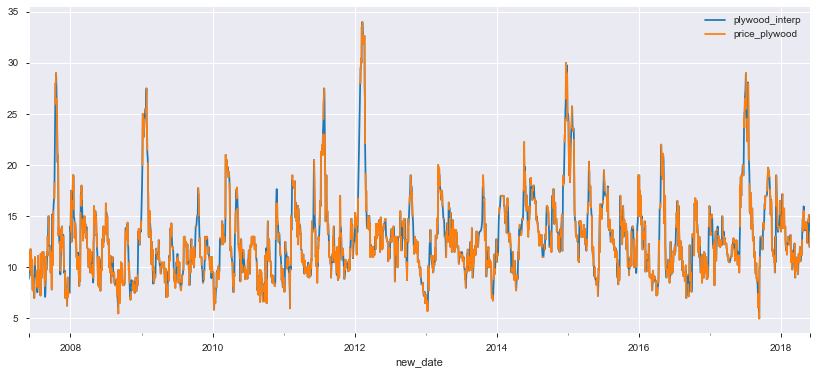

In [191]:
plywood_df['plywood_interp']=plywood_df['price_plywood'].interpolate(method='akima')
ax = plywood_df.plot(x='new_date',y='plywood_interp',figsize=(14,6))
plywood_df.plot(x='new_date',y='price_plywood',figsize=(14,6),ax=ax)

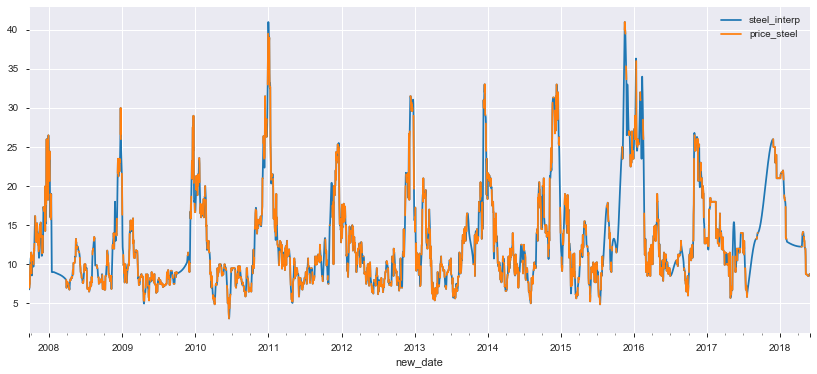

In [192]:
steel_df['steel_interp']=steel_df['price_steel'].interpolate(method='akima')
ax = steel_df.plot(x='new_date',y='steel_interp',figsize=(14,6))
steel_df.plot(x='new_date',y='price_steel',figsize=(14,6),ax=ax)

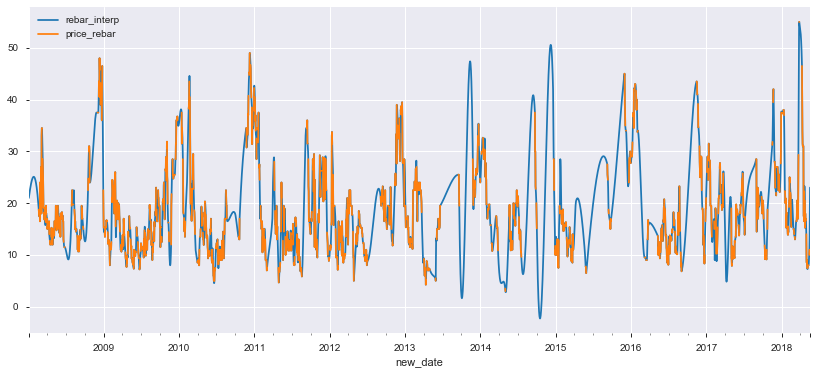

In [21]:
rebar_df['rebar_interp']=rebar_df['price_rebar'].interpolate(method='akima')
ax = rebar_df.plot(x='new_date',y='rebar_interp',figsize=(14,6))
rebar_df.plot(x='new_date',y='price_rebar',figsize=(14,6),ax=ax)

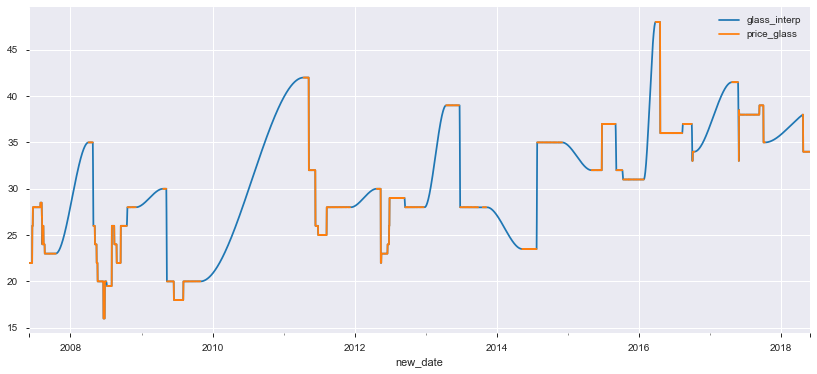

In [22]:
glass_df['glass_interp']=glass_df['price_glass'].interpolate(method='akima')
ax = glass_df.plot(x='new_date',y='glass_interp',figsize=(14,6))
glass_df.plot(x='new_date',y='price_glass',figsize=(14,6),ax=ax)

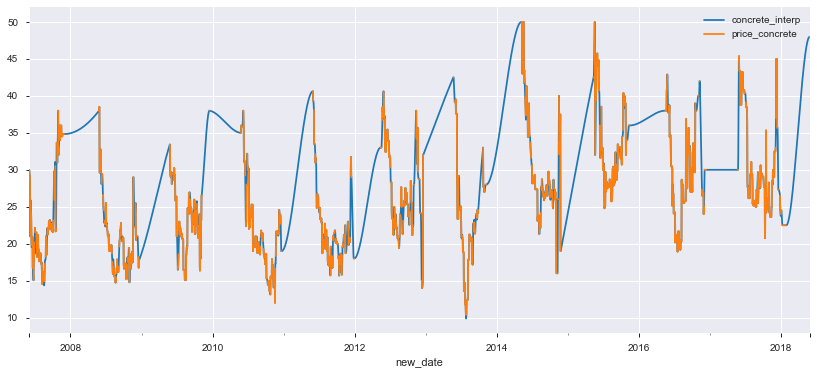

In [23]:
concrete_df['concrete_interp']=concrete_df['price_concrete'].interpolate(method='akima')
ax = concrete_df.plot(x='new_date',y='concrete_interp',figsize=(14,6))
concrete_df.plot(x='new_date',y='price_concrete',figsize=(14,6),ax=ax)

## Interpolation takeaways

- Plywood looks great
- Steal is mostly great except for a bit of missing data in 2017, but the interpolation looks workable.
- Rebar has some large chunks of missing data but the interpolation looks to be representing season trends well enough.
- glass looks odd with all the missing data but probably is workable, 
- concreate is similar story to glass

# Aggregate Box Plots and Seasonal Decomposition.

Let's see how much we can learn just from pooling the data on a few time scales as well as running statsmodels seasonal decompostions plots which could come in useful later when trying to fit a SARIMAX model.

In [24]:
def add_timescales(df):
    df['month'] = df.new_date.dt.month
    df['week'] = df.new_date.dt.week
    return df

In [25]:
plywood_df= add_timescales(plywood_df)
rebar_df= add_timescales(rebar_df)
steel_df= add_timescales(steel_df)
glass_df= add_timescales(glass_df)
concrete_df= add_timescales(concrete_df)

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 12,10

def plot_aggs(df, col):
    plt.figure(figsize=(14,8))
    ax=sns.boxplot(x='month',y=col,data = df)
    plt.figure(figsize=(14,8))
    ax=sns.boxplot(x='week',y=col,data = df)
    decomposition = seasonal_decompose(df.set_index('new_date')[col].resample('MS').mean(), model='additive')
    fig = decomposition.plot()
    plt.show()

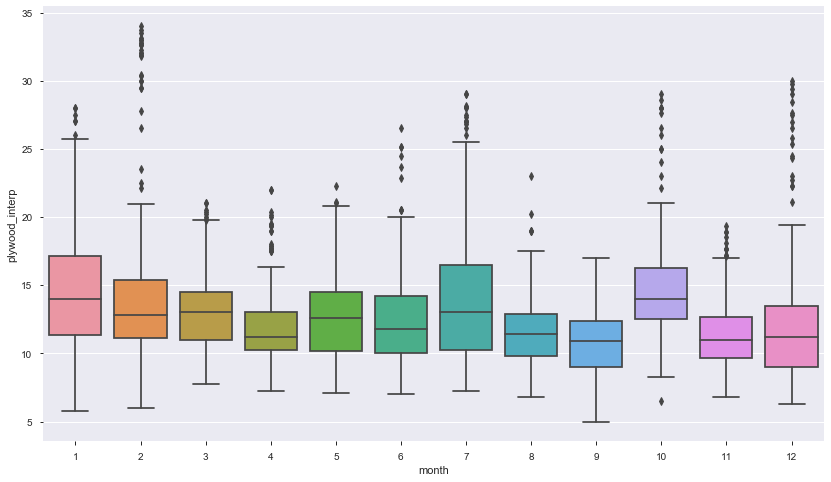

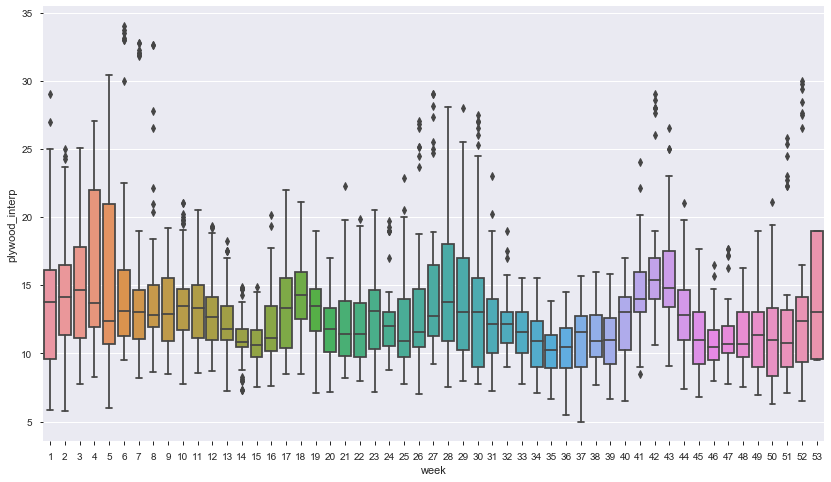

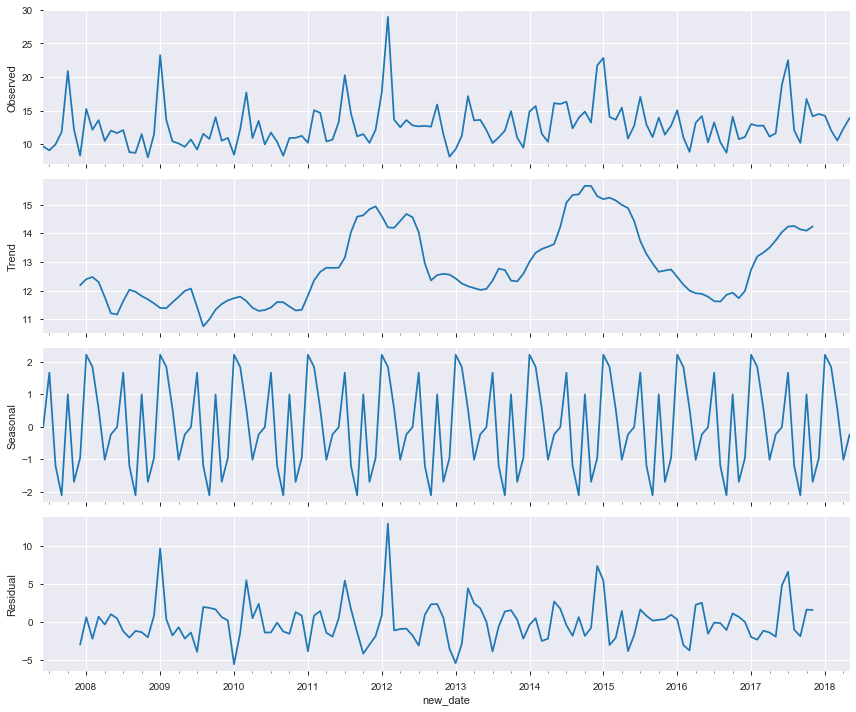

In [27]:
plot_aggs(plywood_df,'plywood_interp')

## Plywood Takeaways

- Possible slight trend up over the years
- Seasonality isn't too clear, but maybe 3 times a year, or every 4 months?
- Still a bit of residuals after taking away trend and seasonality
- prices seem lowest in Sept and highest in Jan but Oct is always 2nd highest. Hard to recommend a buying habit from this data so far.

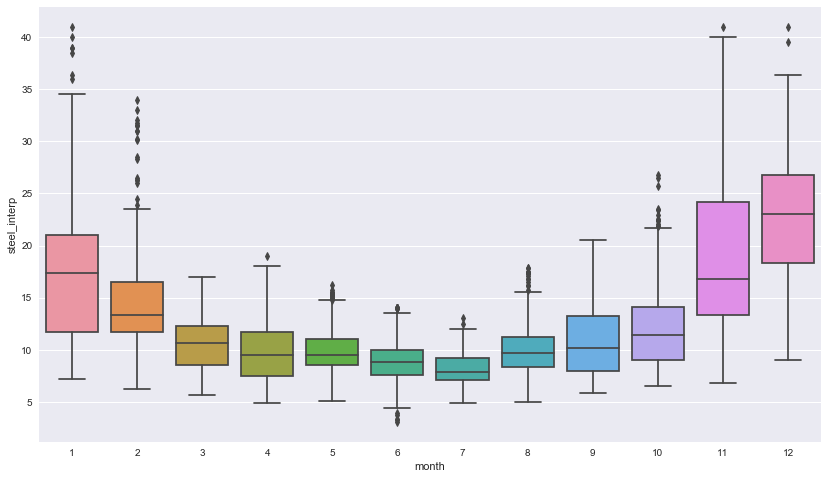

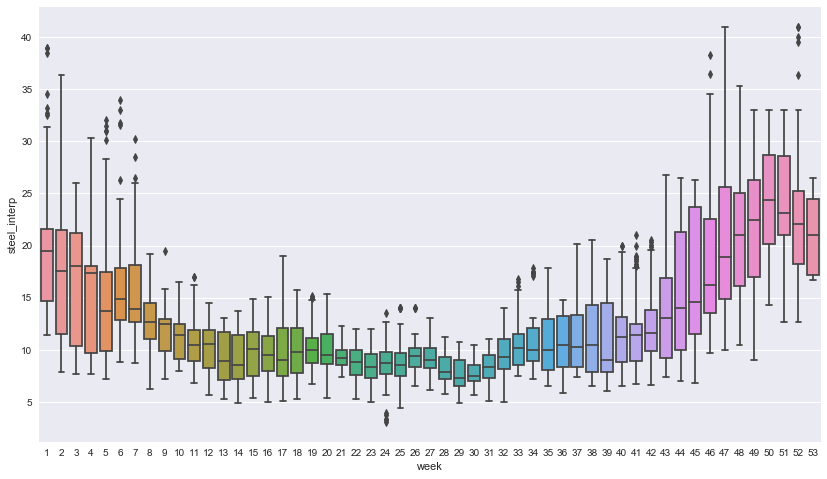

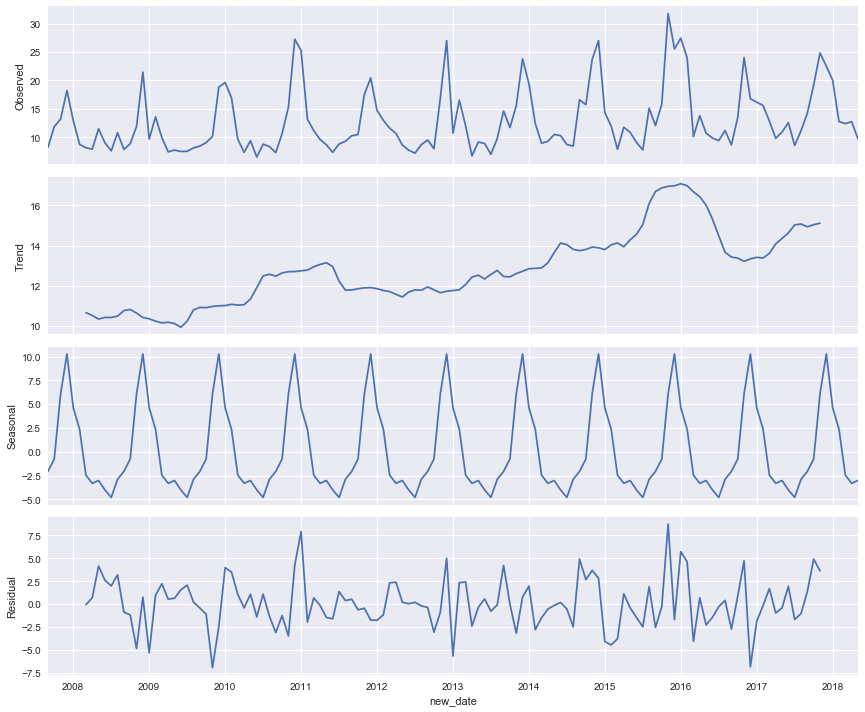

In [463]:
plot_aggs(steel_df,'steel_interp')

## Steel Takeaways

- Clear yearly seasonality. 
- Prices always seem higher in December and Lower in July.
- Slight upward trend on the order of \$4 over the years.

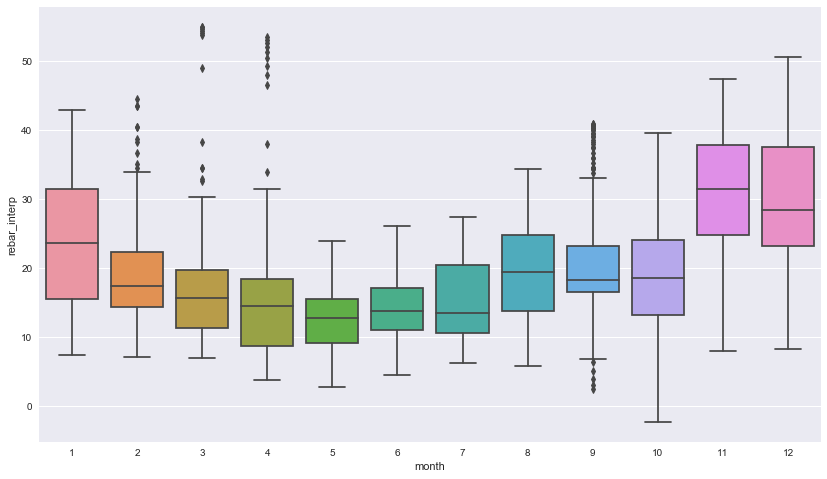

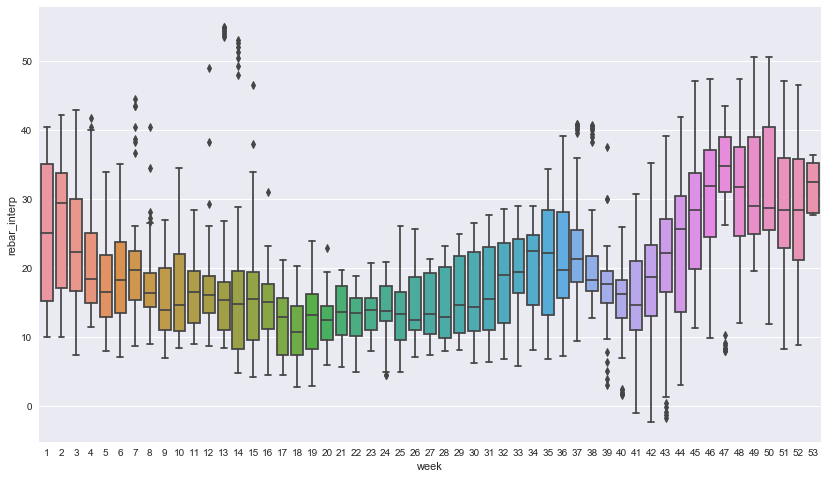

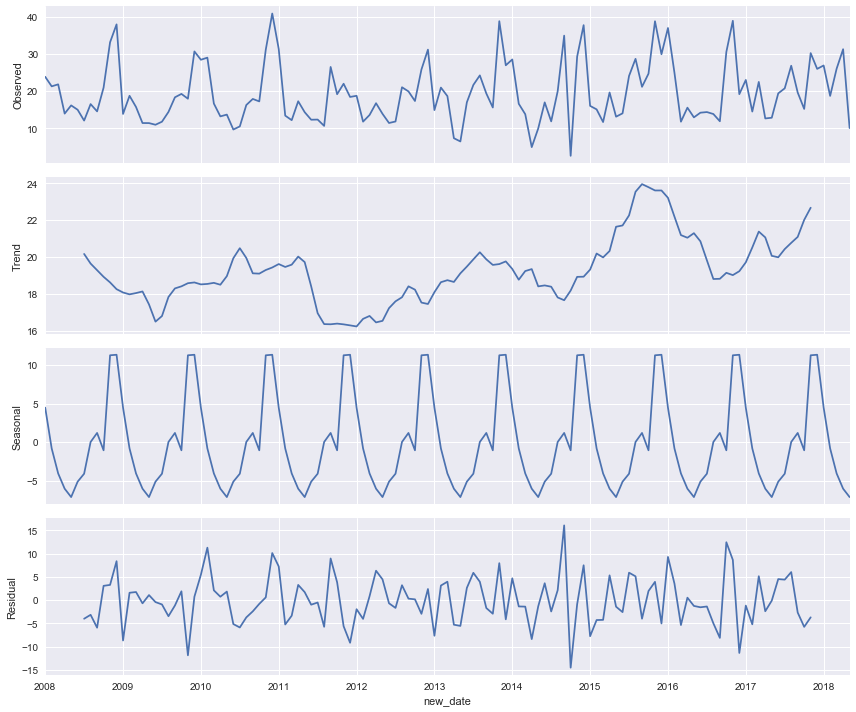

In [464]:
plot_aggs(rebar_df,'rebar_interp')

## Rebar Takeaways

- Similar to Steel. Yearly seasonality.
- Prices dip lower earlier though, in May. But still peak in Dec.
- small upward trend.

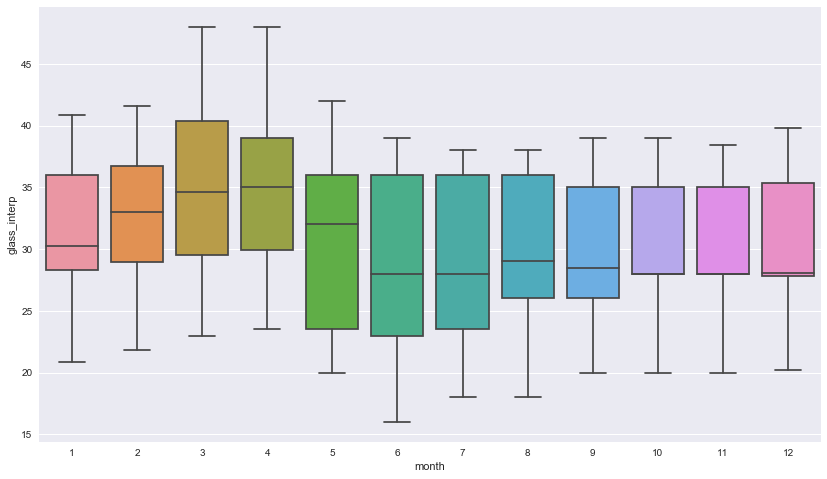

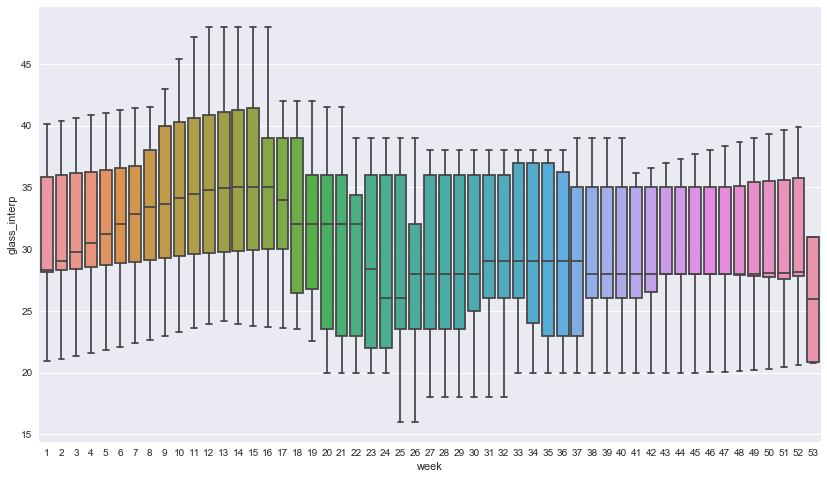

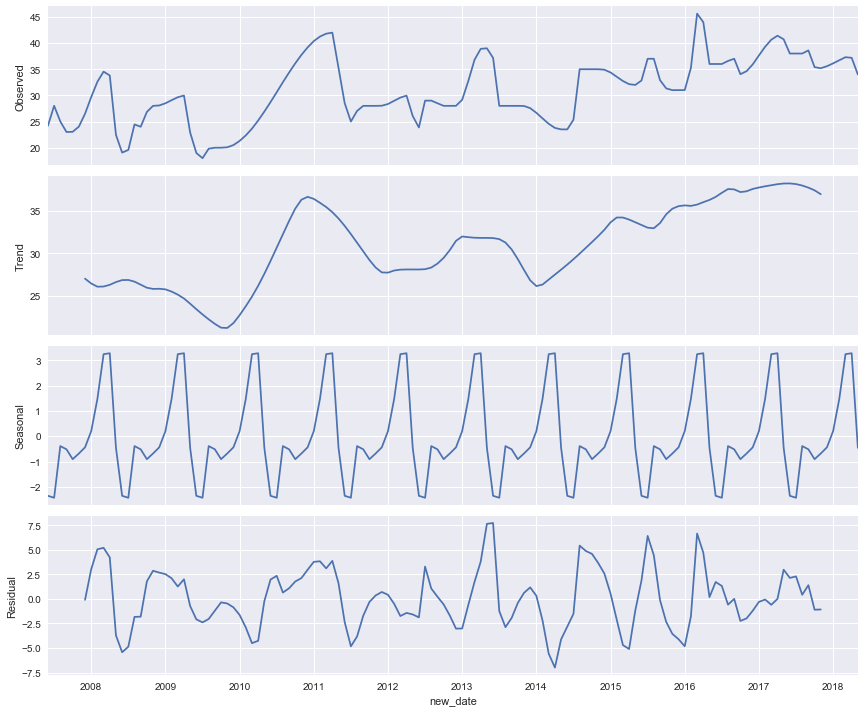

In [465]:
plot_aggs(glass_df,'glass_interp')

## Glass Takeaways

- With all the missing data. Glass is a bit tricky but there is a clear upward trend
- Possible yearly seasonality with a peak in April and a low in June


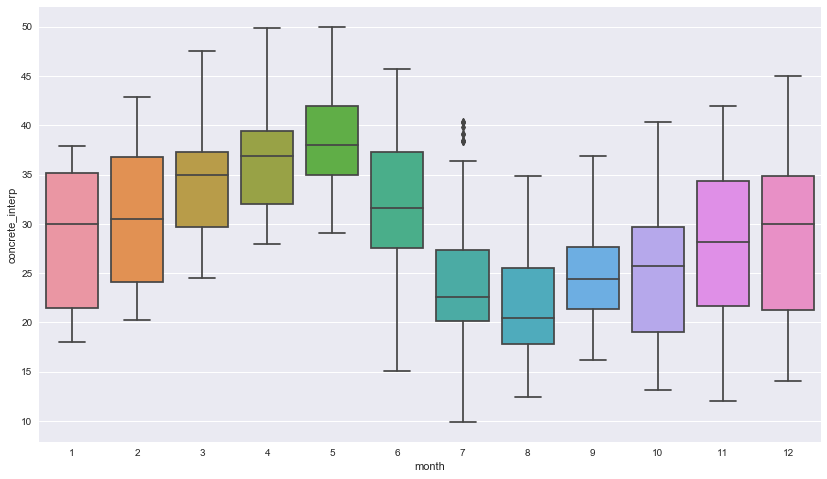

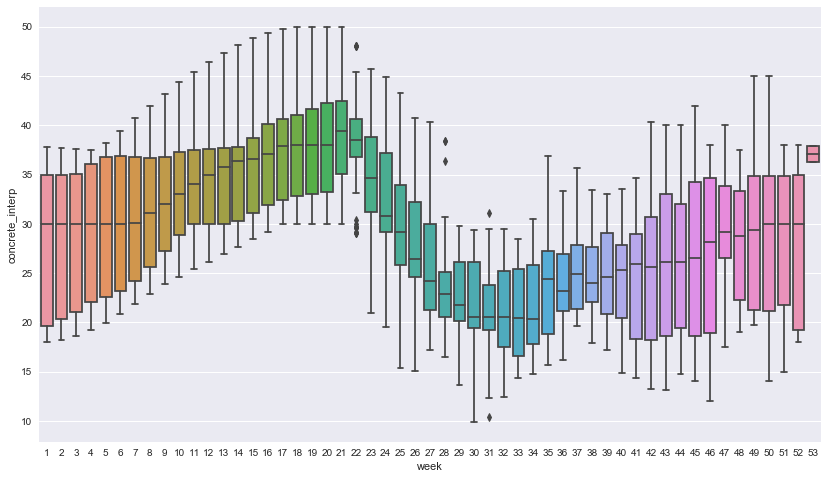

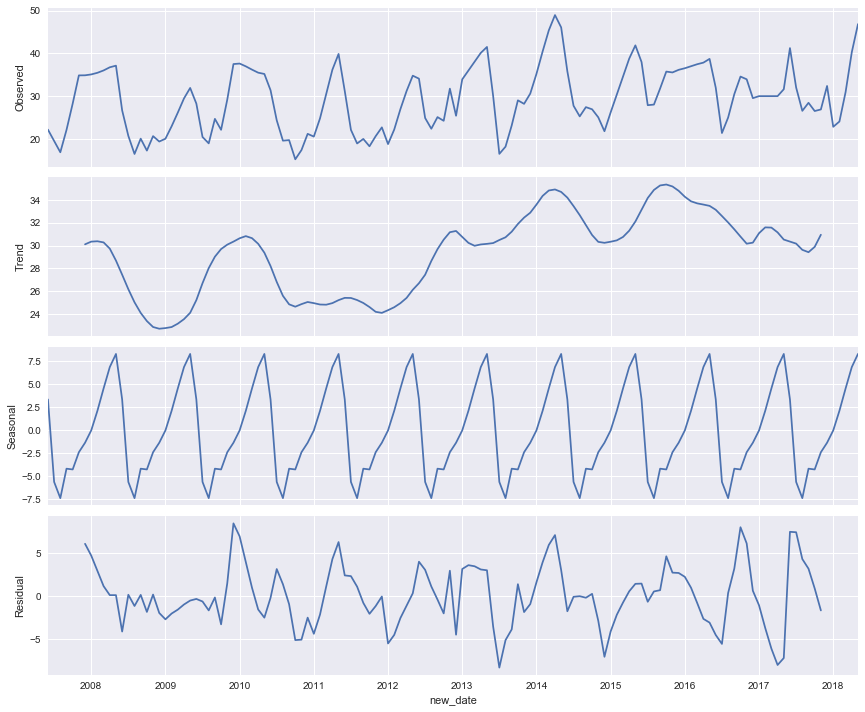

In [466]:
plot_aggs(concrete_df,'concrete_interp')

## Concreate Takeaways

- Clearly yearly seasonality with peak in May and a low in August.
- Not really an upward trend but maybe a shift in 2013. Might want to train data only after 2013 in a model later

# Recommendations So Far

This analysis might be enough at this point, at least for steel, rebar, and concrete, we can recommend:

1. Buy Steel in July
2. Buy Rebar in May
3. Buy Concrete in August.
4. Plywood is a little trickier. You'd want to buy in Sept or Nov, but not Oct and note that the behavior isn't exactly yearly.
5. As for glass, it's hard to recommend anything based on the data but might want to buy in June.

# Time Series models

Below I'll grid search a SARIMAX model for steel and investigate the performance, then compare it to facebook prophet models for the rest of the commodities because it's fast and flexibile.

## SARIMAX

Let's set up a function to grid search the parameters of a SARIMAX model. This is a seasonal ARIMA model that can handle trending.

In [507]:
%%capture
from tqdm import tqdm_notebook as tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
tqdm().pandas()

In [516]:
import itertools
def gridsearch_sarimax(ts,s=12):
    p = d = q = range(0, 3)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(p, d, q))]
    models = []
    num_models = len(pdq)*len(seasonal_pdq)
    c=1
    for param in tqdm(pdq):
        for param_seasonal in tqdm(seasonal_pdq):
            try:
                mod = SARIMAX(ts,
                              order=param,
                              seasonal_order=param_seasonal,
                              trend='ct',
                              enforce_stationarity=False,
                              enforce_invertibility=False
                             )
                results = mod.fit()
                models.append(['ARIMA{}x{}'.format(param, param_seasonal), results.aic])
            except Exception as e:
                print(e)
                continue
    return pd.DataFrame(models,columns=['model','AIC']).sort_values('AIC')

The above function expects data on a monthly scale which will fit a lot faster than if we stick to daily. So let's send in the data resampled at month-state ('MS').

### Steel

In [517]:
gridsearch_sarimax(steel_df.set_index('new_date').steel_interp.resample('MS').mean())

model         AIC
62   ARIMA(0, 0, 2)x(0, 2, 2, 12)  453.360817
386  ARIMA(1, 1, 2)x(0, 2, 2, 12)  455.730516
71   ARIMA(0, 0, 2)x(1, 2, 2, 12)  455.909572
647  ARIMA(2, 1, 2)x(2, 2, 2, 12)  456.011973
305  ARIMA(1, 0, 2)x(0, 2, 2, 12)  456.470598
404  ARIMA(1, 1, 2)x(2, 2, 2, 12)  456.513097
548  ARIMA(2, 0, 2)x(0, 2, 2, 12)  457.929963
566  ARIMA(2, 0, 2)x(2, 2, 2, 12)  459.335977
278  ARIMA(1, 0, 1)x(0, 2, 2, 12)  459.591048
323  ARIMA(1, 0, 2)x(2, 2, 2, 12)  459.731169
629  ARIMA(2, 1, 2)x(0, 2, 2, 12)  460.041798
44   ARIMA(0, 0, 1)x(1, 2, 2, 12)  460.565464
287  ARIMA(1, 0, 1)x(1, 2, 2, 12)  461.575514
314  ARIMA(1, 0, 2)x(1, 2, 2, 12)  461.749185
638  ARIMA(2, 1, 2)x(1, 2, 2, 12)  462.034998
80   ARIMA(0, 0, 2)x(2, 2, 2, 12)  462.728976
557  ARIMA(2, 0, 2)x(1, 2, 2, 12)  463.253697
602  ARIMA(2, 1, 1)x(0, 2, 2, 12)  463.509341
251  ARIMA(1, 0, 0)x(0, 2, 2, 12)  464.239168
565  ARIMA(2, 0, 2)x(2, 2, 1, 12)  464.402161
611  ARIMA(2, 1, 1)x(1, 2, 2, 12)  464.688710
161  ARIMA(0, 1, 2)x(2, 2, 2, 12)  465.464447
593  ARIMA(2, 1, 0)x(2, 2, 2, 12)  465.484719
592  ARIMA(2, 1, 0)x(2, 2, 1, 12)  465.527393
260  ARIMA(1, 0, 0)x(1, 2, 2, 12)  466.056701
8    ARIMA(0, 0, 0)x(0, 2, 2, 12)  466.288641
395  ARIMA(1, 1, 2)x(1, 2, 2, 12)  466.315922
53   ARIMA(0, 0, 1)x(2, 2, 2, 12)  466.396202
296  ARIMA(1, 0, 1)x(2, 2, 2, 12)  466.775529
620  ARIMA(2, 1, 1)x(2, 2, 2, 12)  467.163944
..                            ...         ...
135  ARIMA(0, 1, 2)x(0, 0, 0, 12)  741.415113
270  ARIMA(1, 0, 1)x(0, 0, 0, 12)  742.043810
513  ARIMA(2, 0, 1)x(0, 0, 0, 12)  742.909392
406  ARIMA(1, 2, 0)x(0, 0, 1, 12)  743.197448
654  ARIMA(2, 2, 0)x(0, 2, 0, 12)  744.772253
27   ARIMA(0, 0, 1)x(0, 0, 0, 12)  745.389497
351  ARIMA(1, 1, 1)x(0, 0, 0, 12)  745.844646
243  ARIMA(1, 0, 0)x(0, 0, 0, 12)  747.833461
702  ARIMA(2, 2, 2)x(0, 0, 0, 12)  761.737859
216  ARIMA(0, 2, 2)x(0, 0, 0, 12)  763.535295
459  ARIMA(1, 2, 2)x(0, 0, 0, 12)  765.082924
108  ARIMA(0, 1, 1)x(0, 0, 0, 12)  766.523905
189  ARIMA(0, 2, 1)x(0, 0, 0, 12)  766.758009
594  ARIMA(2, 1, 1)x(0, 0, 0, 12)  766.863907
567  ARIMA(2, 1, 0)x(0, 0, 0, 12)  766.967608
408  ARIMA(1, 2, 0)x(0, 1, 0, 12)  768.653963
172  ARIMA(0, 2, 0)x(1, 0, 1, 12)  769.810905
81   ARIMA(0, 1, 0)x(0, 0, 0, 12)  770.884549
324  ARIMA(1, 1, 0)x(0, 0, 0, 12)  771.947711
675  ARIMA(2, 2, 1)x(0, 0, 0, 12)  772.923712
171  ARIMA(0, 2, 0)x(1, 0, 0, 12)  775.985120
163  ARIMA(0, 2, 0)x(0, 0, 1, 12)  776.176955
432  ARIMA(1, 2, 1)x(0, 0, 0, 12)  776.359255
411  ARIMA(1, 2, 0)x(0, 2, 0, 12)  793.862419
0    ARIMA(0, 0, 0)x(0, 0, 0, 12)  795.807030
648  ARIMA(2, 2, 0)x(0, 0, 0, 12)  802.137283
165  ARIMA(0, 2, 0)x(0, 1, 0, 12)  808.746168
168  ARIMA(0, 2, 0)x(0, 2, 0, 12)  830.895460
405  ARIMA(1, 2, 0)x(0, 0, 0, 12)  831.373899
162  ARIMA(0, 2, 0)x(0, 0, 0, 12)  863.431439

[729 rows x 2 columns]

So it looks like a SARIMAX model with params (0, 0, 2),(0, 2, 2, 12) and an AIC 453.360817 is best for steel with a 12 month seasononality and trend = 'ct'. 

Lets fit this model and see how forecasts look:

In [520]:
X = steel_df.set_index('new_date').steel_interp.resample('MS').mean()

mod = SARIMAX(X,
            order=(0,0,2),
            seasonal_order=(0,2,2,12),
            trend='ct',
            enforce_stationarity=False,
            enforce_invertibility=False)

results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0654      0.690     -0.095      0.924      -1.419       1.288
drift          0.0002      0.009      0.017      0.987      -0.018       0.018
ma.L1          0.2892      0.117      2.462      0.014       0.059       0.520
ma.L2         -0.0523      0.172     -0.305      0.760      -0.389       0.284
ma.S.L12      -1.9459    186.887     -0.010      0.992    -368.237     364.345
ma.S.L24       0.9984    191.431      0.005      0.996    -374.198     376.195
sigma2         9.8936   1899.123      0.005      0.996   -3712.319    3732.106


P values not great except for ma.L1 coef but ok, Let's see the diagnostics.

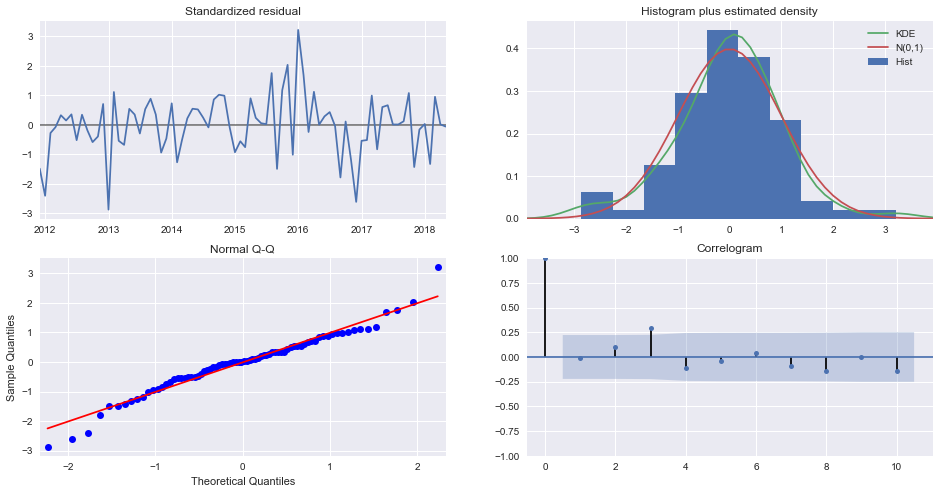

In [521]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

- 2016 maybe violates this but overall it look reasonable.
- model could be improved by exploring a wider range of SARIMAX parameters but it will take a lot of time.

Let's move on to validating the model by forecasting data within the given timespan and calculating RMSE. we will use dynamic=True in the get_prediction function which means the model will use the last forecasting datapoint for each prediction instead of the actuall data, so this will be a true test of the forecasting ability of the model. If it looks good then we can assume the out-of-sample forecasting will be trustworth, at least for a period of time.

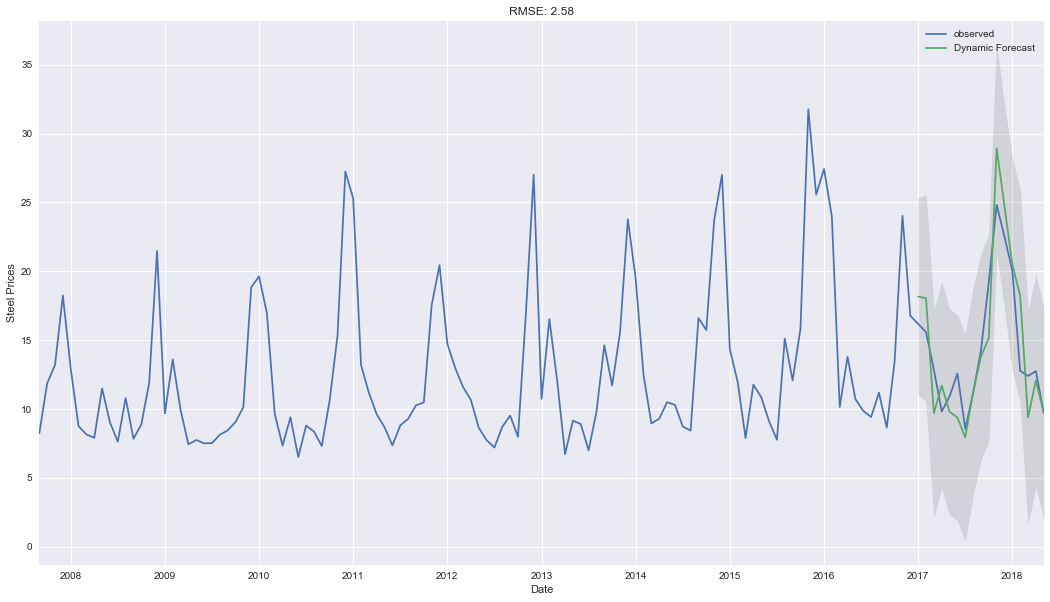

In [567]:
pred_dynamic = results.get_prediction(
    start = pd.to_datetime('2017-01-01'),
#     end = pd.to_datetime('2019-05-01'),
    dynamic=True, full_results=True
)

pred_dynamic_ci = pred_dynamic.conf_int()

ax = X['2004':].plot(label='observed', figsize=(18, 10))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.1)

ax.set_xlabel('Date')
ax.set_ylabel('Steel Prices')

rmse = np.sqrt(mean_squared_error(X['2017':],pred_dynamic.predicted_mean))
plt.title('RMSE: {:.2f}'.format(rmse))

plt.legend()
plt.show()

Steel prices range from 7 to 35 so with an RMSE of 2.58, I'd say this is a pretty good fit that we can trust for out of sample forecasts. So let's see what the next several years of prices look like.

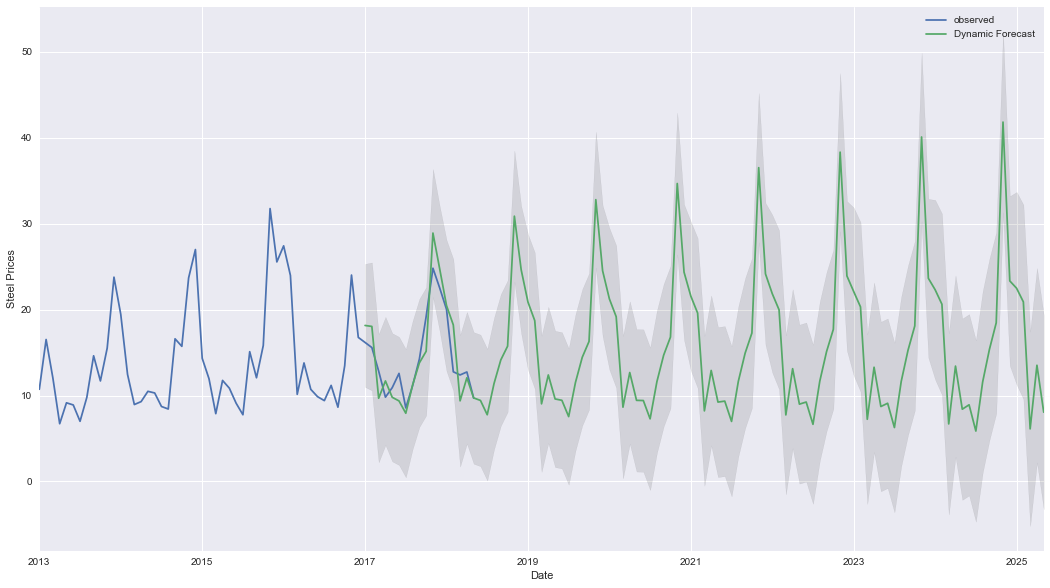

In [571]:
pred_dynamic = results.get_prediction(
    start = pd.to_datetime('2017-01-01'),
    end = pd.to_datetime('2025-05-01'),
    dynamic=True, full_results=True
)

pred_dynamic_ci = pred_dynamic.conf_int()

ax = X['2013':].plot(label='observed', figsize=(18, 10))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.1)

ax.set_xlabel('Date')
ax.set_ylabel('Steel Prices')

plt.legend()
plt.show()

Far in the future, the model keeps increasing it's seasonal range, this is obviously something we need to be careful about and compensate for by feeding in the latest real data to retrain the model and only trust predictions maybe up to a year out.

### Rebar

Let's try rebar now

In [551]:
gridsearch_sarimax(rebar_df.set_index('new_date').rebar_interp.resample('MS').mean())

model         AIC
62   ARIMA(0, 0, 2)x(0, 2, 2, 12)  529.690407
548  ARIMA(2, 0, 2)x(0, 2, 2, 12)  532.862665
305  ARIMA(1, 0, 2)x(0, 2, 2, 12)  533.983026
71   ARIMA(0, 0, 2)x(1, 2, 2, 12)  534.551171
80   ARIMA(0, 0, 2)x(2, 2, 2, 12)  535.671284
314  ARIMA(1, 0, 2)x(1, 2, 2, 12)  536.523672
323  ARIMA(1, 0, 2)x(2, 2, 2, 12)  536.720035
35   ARIMA(0, 0, 1)x(0, 2, 2, 12)  536.840578
521  ARIMA(2, 0, 1)x(0, 2, 2, 12)  536.933217
278  ARIMA(1, 0, 1)x(0, 2, 2, 12)  537.430935
557  ARIMA(2, 0, 2)x(1, 2, 2, 12)  538.808171
44   ARIMA(0, 0, 1)x(1, 2, 2, 12)  538.979799
566  ARIMA(2, 0, 2)x(2, 2, 2, 12)  539.407823
530  ARIMA(2, 0, 1)x(1, 2, 2, 12)  540.286410
8    ARIMA(0, 0, 0)x(0, 2, 2, 12)  540.293344
512  ARIMA(2, 0, 0)x(2, 2, 2, 12)  540.826069
53   ARIMA(0, 0, 1)x(2, 2, 2, 12)  541.281232
116  ARIMA(0, 1, 1)x(0, 2, 2, 12)  541.963510
296  ARIMA(1, 0, 1)x(2, 2, 2, 12)  541.972147
647  ARIMA(2, 1, 2)x(2, 2, 2, 12)  542.006943
251  ARIMA(1, 0, 0)x(0, 2, 2, 12)  542.256934
494  ARIMA(2, 0, 0)x(0, 2, 2, 12)  543.214630
511  ARIMA(2, 0, 0)x(2, 2, 1, 12)  543.816067
287  ARIMA(1, 0, 1)x(1, 2, 2, 12)  544.013817
539  ARIMA(2, 0, 1)x(2, 2, 2, 12)  544.270997
538  ARIMA(2, 0, 1)x(2, 2, 1, 12)  544.645373
26   ARIMA(0, 0, 0)x(2, 2, 2, 12)  544.884489
602  ARIMA(2, 1, 1)x(0, 2, 2, 12)  544.889203
503  ARIMA(2, 0, 0)x(1, 2, 2, 12)  545.381599
565  ARIMA(2, 0, 2)x(2, 2, 1, 12)  546.469626
..                            ...         ...
438  ARIMA(1, 2, 1)x(0, 2, 0, 12)  859.107097
84   ARIMA(0, 1, 0)x(0, 1, 0, 12)  862.410972
330  ARIMA(1, 1, 0)x(0, 2, 0, 12)  868.721967
414  ARIMA(1, 2, 0)x(1, 0, 0, 12)  869.852071
406  ARIMA(1, 2, 0)x(0, 0, 1, 12)  870.272807
0    ARIMA(0, 0, 0)x(0, 0, 0, 12)  871.299391
415  ARIMA(1, 2, 0)x(1, 0, 1, 12)  871.797753
195  ARIMA(0, 2, 1)x(0, 2, 0, 12)  872.014803
702  ARIMA(2, 2, 2)x(0, 0, 0, 12)  874.162044
108  ARIMA(0, 1, 1)x(0, 0, 0, 12)  874.403008
567  ARIMA(2, 1, 0)x(0, 0, 0, 12)  874.418940
216  ARIMA(0, 2, 2)x(0, 0, 0, 12)  874.572749
675  ARIMA(2, 2, 1)x(0, 0, 0, 12)  875.001373
87   ARIMA(0, 1, 0)x(0, 2, 0, 12)  881.032048
432  ARIMA(1, 2, 1)x(0, 0, 0, 12)  881.561797
651  ARIMA(2, 2, 0)x(0, 1, 0, 12)  883.861548
189  ARIMA(0, 2, 1)x(0, 0, 0, 12)  887.977496
324  ARIMA(1, 1, 0)x(0, 0, 0, 12)  888.267485
81   ARIMA(0, 1, 0)x(0, 0, 0, 12)  895.250579
654  ARIMA(2, 2, 0)x(0, 2, 0, 12)  895.718034
163  ARIMA(0, 2, 0)x(0, 0, 1, 12)  903.495454
172  ARIMA(0, 2, 0)x(1, 0, 1, 12)  904.432076
171  ARIMA(0, 2, 0)x(1, 0, 0, 12)  910.337816
648  ARIMA(2, 2, 0)x(0, 0, 0, 12)  920.764211
408  ARIMA(1, 2, 0)x(0, 1, 0, 12)  931.550377
411  ARIMA(1, 2, 0)x(0, 2, 0, 12)  940.949417
405  ARIMA(1, 2, 0)x(0, 0, 0, 12)  962.211478
165  ARIMA(0, 2, 0)x(0, 1, 0, 12)  963.214161
168  ARIMA(0, 2, 0)x(0, 2, 0, 12)  971.100646
162  ARIMA(0, 2, 0)x(0, 0, 0, 12)  999.473418

[729 rows x 2 columns]

Not surprisingly, we got the same top model paramters as steel.

In [574]:
X = rebar_df.set_index('new_date').rebar_interp.resample('MS').mean()

mod = SARIMAX(X,
            order=(0,0,2),
            seasonal_order=(0,2,2,12),
            trend='ct',
            enforce_stationarity=False,
            enforce_invertibility=False)

results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3974      0.988      0.402      0.687      -1.539       2.334
drift         -0.0027      0.013     -0.204      0.838      -0.028       0.023
ma.L1          0.0550      0.109      0.506      0.613      -0.158       0.268
ma.L2         -0.1896      0.150     -1.266      0.205      -0.483       0.104
ma.S.L12      -1.9591      1.021     -1.918      0.055      -3.961       0.043
ma.S.L24       1.0759      1.227      0.877      0.381      -1.329       3.481
sigma2        37.1750     45.593      0.815      0.415     -52.185     126.535


p values looking better than steel. let's see diagnostics

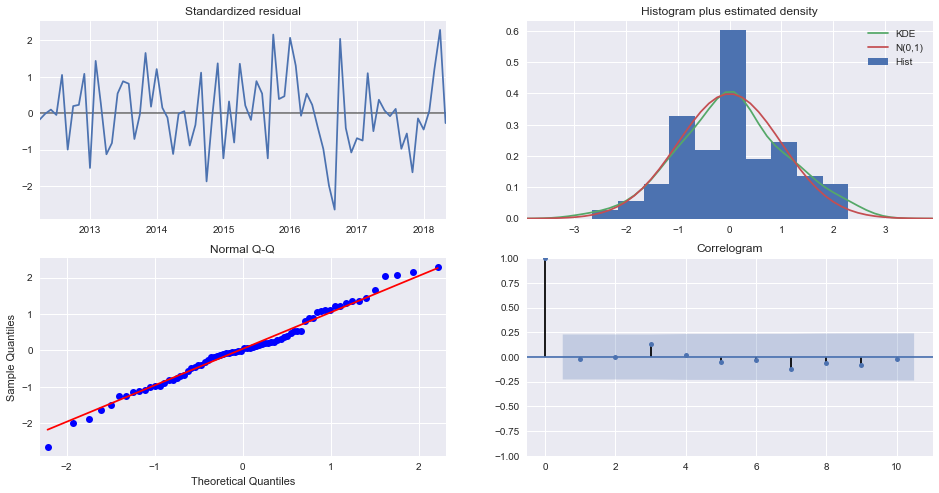

In [575]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

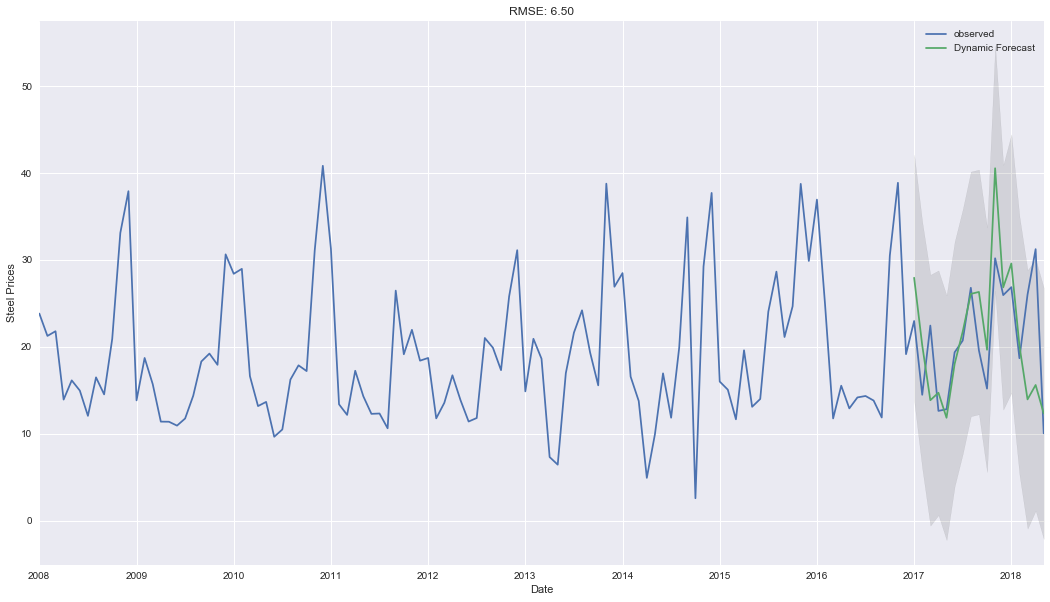

In [576]:
pred_dynamic = results.get_prediction(
    start = pd.to_datetime('2017-01-01'),
#     end = pd.to_datetime('2019-05-01'),
    dynamic=True, full_results=True
)

pred_dynamic_ci = pred_dynamic.conf_int()

ax = X['2004':].plot(label='observed', figsize=(18, 10))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.1)

ax.set_xlabel('Date')
ax.set_ylabel('Steel Prices')

rmse = np.sqrt(mean_squared_error(X['2017':],pred_dynamic.predicted_mean))
plt.title('RMSE: {:.2f}'.format(rmse))

plt.legend()
plt.show()

the rebar data is a little noisier and we got a higher RMSE for it, but 7 compared to the data range of 5 to 40 doesnt seem terrible. Let's do some out of sample forecasts.

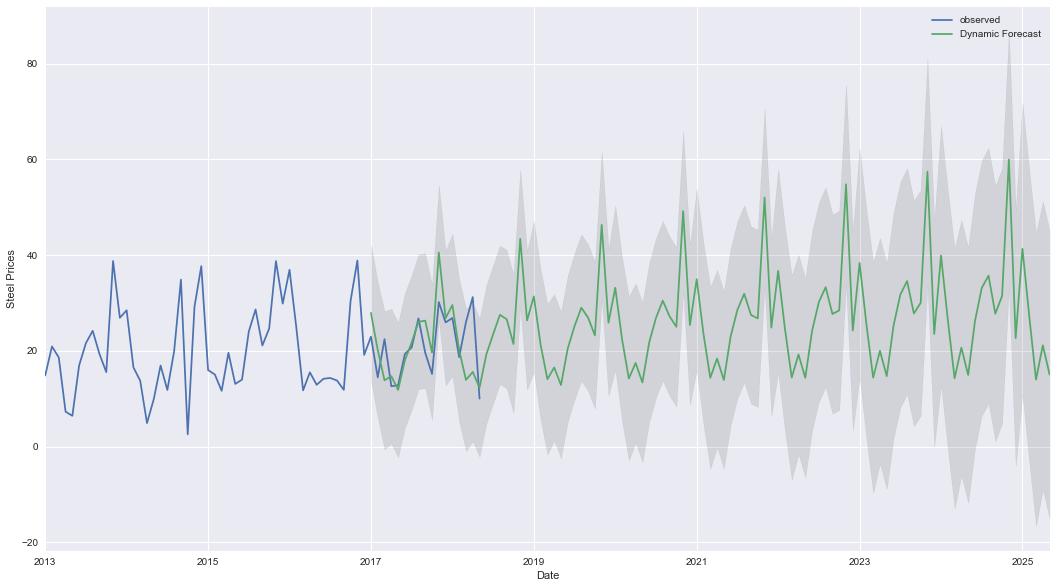

In [577]:
pred_dynamic = results.get_prediction(
    start = pd.to_datetime('2017-01-01'),
    end = pd.to_datetime('2025-05-01'),
    dynamic=True, full_results=True
)

pred_dynamic_ci = pred_dynamic.conf_int()

ax = X['2013':].plot(label='observed', figsize=(18, 10))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.1)

ax.set_xlabel('Date')
ax.set_ylabel('Steel Prices')

plt.legend()
plt.show()

## Facebook Prophet

Let's refit this data with facebook prophet and see what the rmse and future forecasting trends look like.

note the pd.plotting.register_matplotlib_converters() call which is needed to fix some incompatiblities with pandas and fb prophet for matplotlib plotting. This will be unneccessary in a future pandas version that will remove the matplitlib converter registration that pandas is currently doing on import.


In [46]:
from fbprophet import Prophet
import fbprophet as prophet
pd.plotting.register_matplotlib_converters()

In [31]:
df = steel_df[['new_date','steel_interp']].rename(columns = {'new_date':'ds','steel_interp':'y'})

In [56]:
df['ds']=pd.DatetimeIndex(df['ds'])
df = df.set_index('ds').resample('MS').mean()

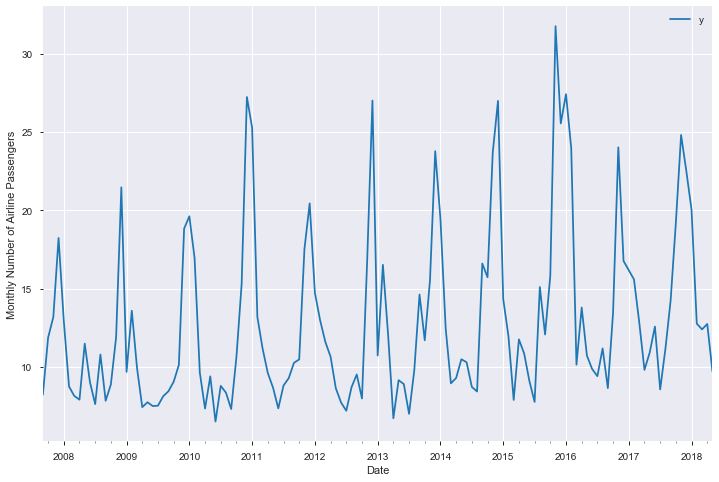

In [58]:
ax = df.plot(figsize=(12, 8))
ax.set_ylabel('Monthly Number of Airline Passengers')
ax.set_xlabel('Date')

plt.show()

In [59]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95)

In [61]:
my_model.fit(df.reset_index())

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [84]:
pred_dates = df['2017':].reset_index()

In [85]:
forecast = my_model.predict(pred_dates[['ds']])
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds       yhat  yhat_lower  yhat_upper
12 2018-01-01  19.837241   14.161143   25.737413
13 2018-02-01  17.000163   11.465500   23.113057
14 2018-03-01  12.976079    7.230618   19.079495
15 2018-04-01  12.305120    6.406470   18.217816
16 2018-05-01  12.355357    6.696851   18.173622

Text(0.5, 1, 'RMSE: 2.29')

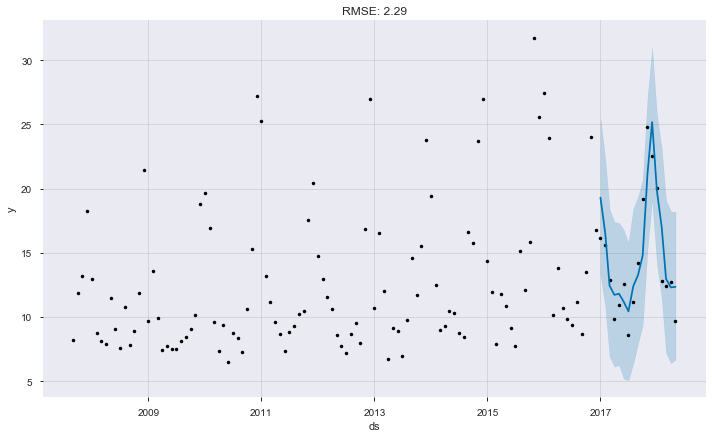

In [88]:
my_model.plot(forecast,
              uncertainty=True)

rmse = np.sqrt(mean_squared_error(pred_dates['y'],forecast['yhat']))
plt.title('RMSE: {:.2f}'.format(rmse))

We got a better RMSE than the same predictions from our SARIMAX model and overall the model choose it's parameters quite fast.

Let's see the rmse when we predict on a daily granularity

In [ ]:
rmse = np.sqrt(mean_squared_error(pred_dates['y'],forecast['yhat']))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1, 'RMSE: 2.88')

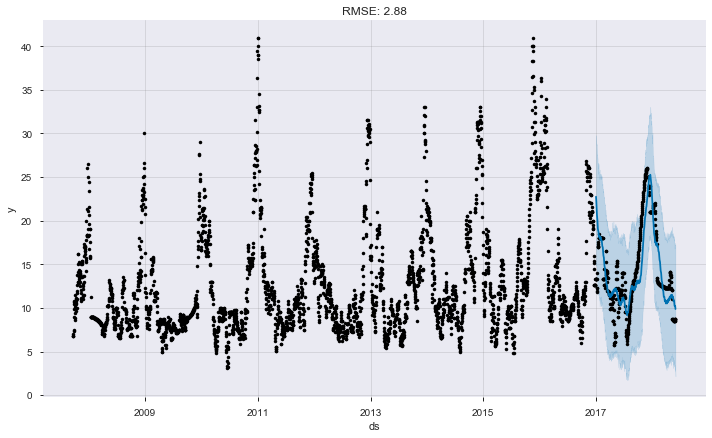

In [96]:
df = steel_df[['new_date','steel_interp']].rename(columns = {'new_date':'ds','steel_interp':'y'})

my_model = Prophet(interval_width=0.95)

my_model.fit(df)

pred_dates = df.set_index('ds')['2017':].reset_index()

forecast = my_model.predict(pred_dates[['ds']])

rmse = np.sqrt(mean_squared_error(pred_dates['y'],forecast['yhat']))

my_model.plot(forecast,
              uncertainty=True)
plt.title('RMSE: {:.2f}'.format(rmse))


Still a great RMSE. 

Let's see the forecast predictions like we did before:

In [99]:
future_dates = my_model.make_future_dataframe(periods=2190,include_history=True)

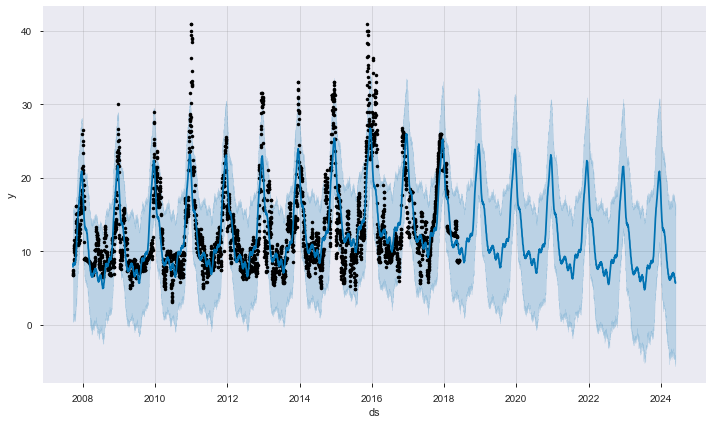

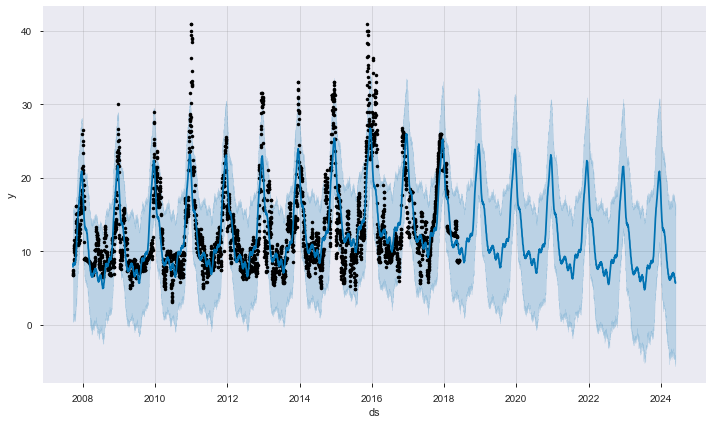

In [100]:
forecast = my_model.predict(future_dates)
my_model.plot(forecast,
              uncertainty=True)

Not sure why the prediction trend starting going down. Let's retry this on the monthly scale

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


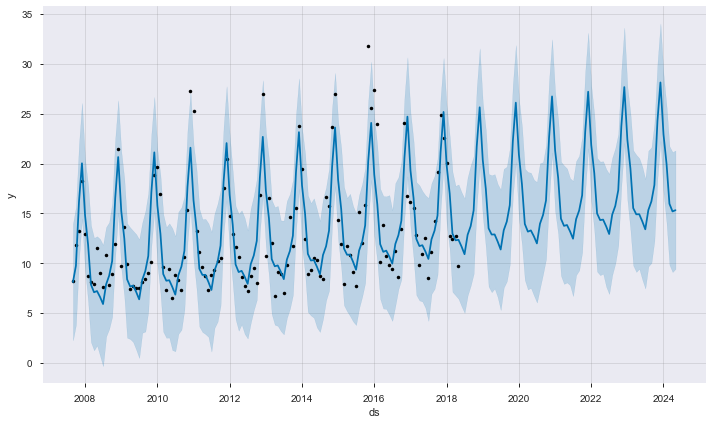

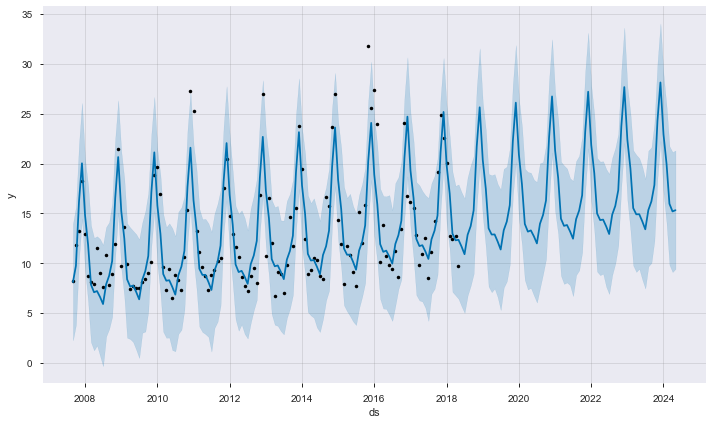

In [104]:
df = steel_df[['new_date','steel_interp']].rename(columns = {'new_date':'ds','steel_interp':'y'})
df = df.set_index('ds').resample('MS').mean()

my_model = Prophet(interval_width=0.95)

my_model.fit(df.reset_index())

future_dates = my_model.make_future_dataframe(periods=72, freq='MS', include_history=True)
forecast = my_model.predict(future_dates)
my_model.plot(forecast,
              uncertainty=True)


This trend is the opposite, ever increasing which seems to better track the historical data so I think it's best to go with monthly averages. 

Let's now create a function that will work for the rest of the commodities to plot the 2017 in sample RMSE and the 6 year forecasts.

I'm also going to add a parameter to the model to make the detection of trend change_points more flexible. This might reduce RMSE but could overfit and lead to bad future forecasts. The default for changepoint_prior_scale = 0.05. Any discovered changepoints will be marked by vertical red dashed lines in the figures.

In [160]:
from fbprophet.plot import add_changepoints_to_plot
def fit_plot_prophet(df,y_col):
    
    df = df[['new_date',y_col]].rename(columns = {'new_date':'ds',y_col:'y'})
    df = df.set_index('ds').resample('MS').mean()

    my_model = Prophet(
        interval_width=0.95,
        changepoint_prior_scale=.15
    )

    my_model.fit(df.reset_index())

    # in sample validation
    pred_dates = df['2016':].reset_index()
    forecast = my_model.predict(pred_dates[['ds']])
    rmse = np.sqrt(mean_squared_error(pred_dates['y'],forecast['yhat']))
    my_model.plot(forecast,
                  uncertainty=True)
    plt.title('RMSE: {:.2f}'.format(rmse))


    # out of sample forecast
    future_dates = my_model.make_future_dataframe(periods=72, freq='MS', include_history=True)
    forecast = my_model.predict(future_dates)
    fig=my_model.plot(forecast,
                  uncertainty=True)
    plt.title('6 year Future Forecasts')
    a = add_changepoints_to_plot(fig.gca(), my_model, forecast)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


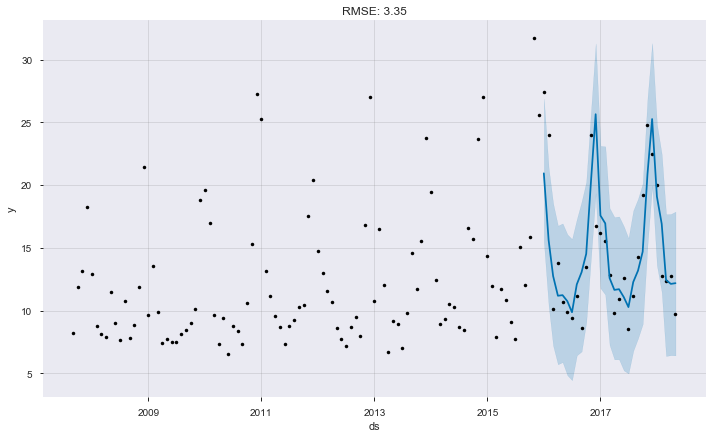

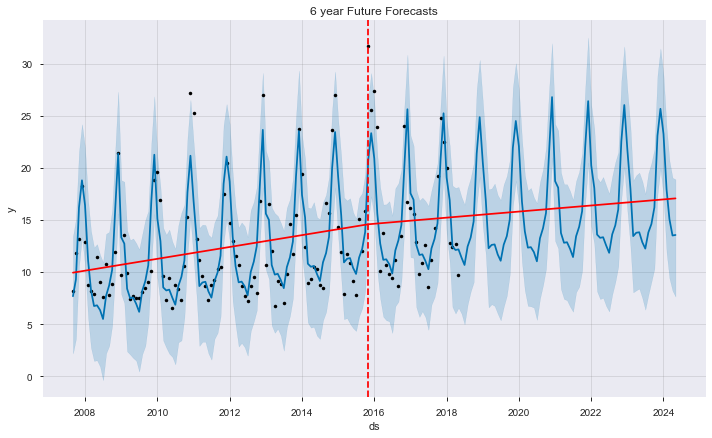

In [161]:
fit_plot_prophet(steel_df,'steel_interp')

### Steel Summary

The steel fit seems quite good and is probably trustworthy at least a year out if not further. The uncertainty is small enough that the seasonaly and trend looks to be quite useful.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


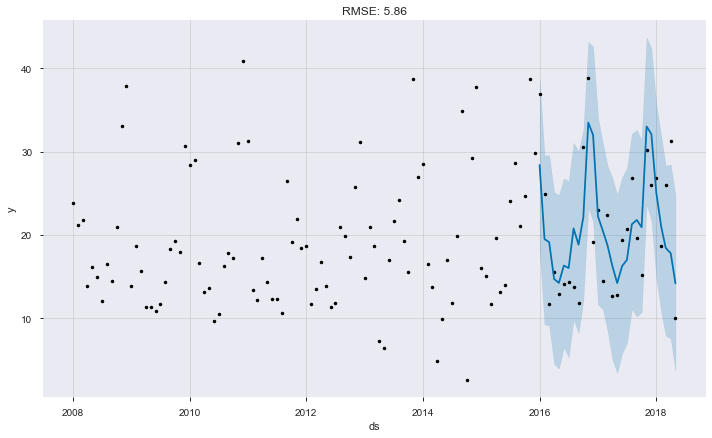

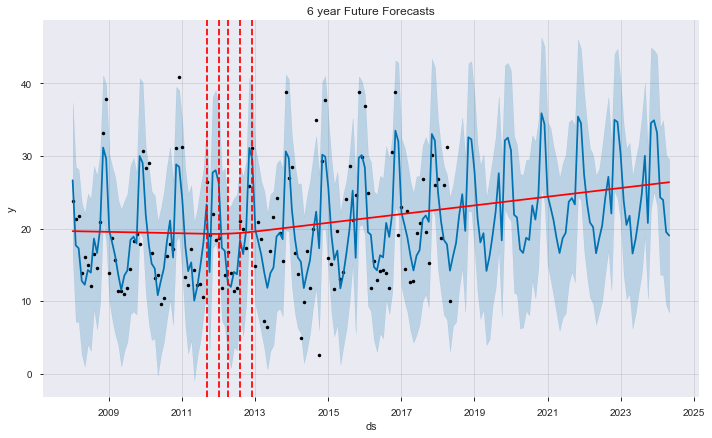

In [162]:
fit_plot_prophet(rebar_df,'rebar_interp')

### Rebar fit

Similar to steel but with a little more uncertainty. Again it would be nice if we could fit to multivariate data of both steel and rebar prices since they are correlated.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


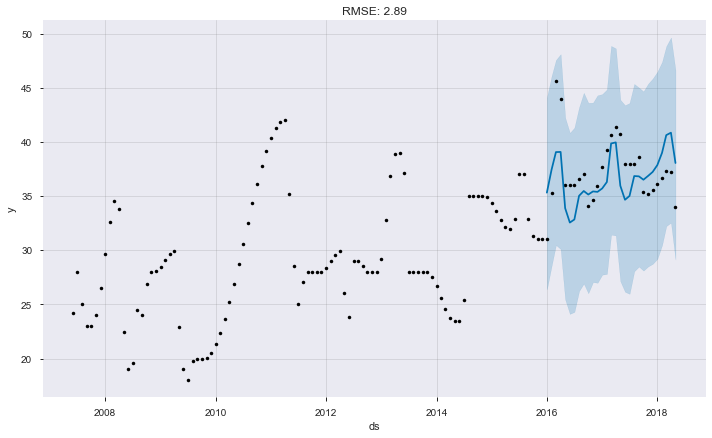

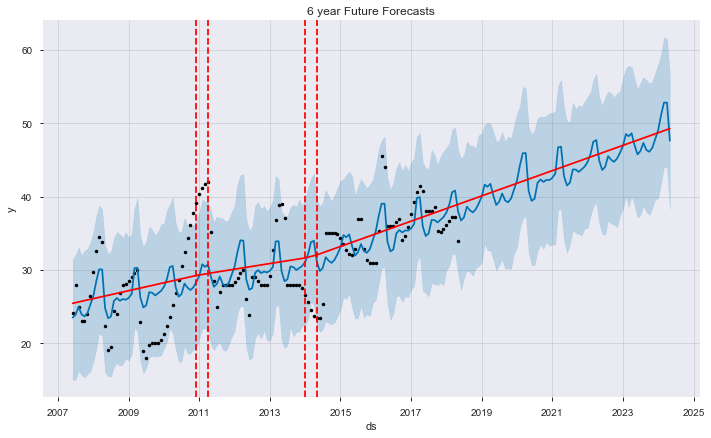

In [163]:
fit_plot_prophet(glass_df,'glass_interp')

### Glass fit

I think the model picked out the overall trend well and some of the seasonality although the magnitude of spikes is hard to predict and the uncertainty remains high.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


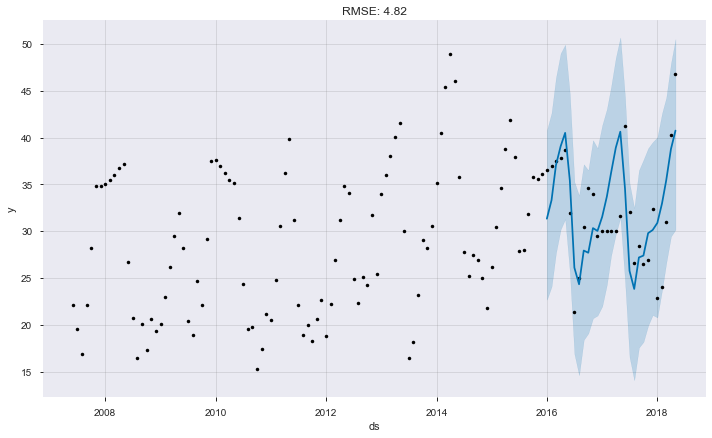

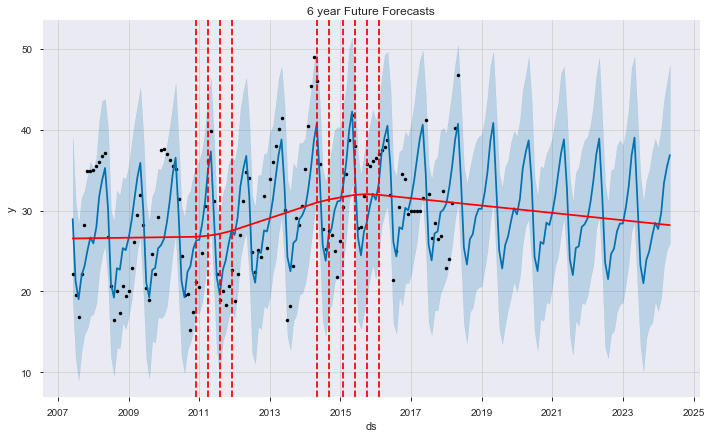

In [164]:
fit_plot_prophet(concrete_df,'concrete_interp')

### Concrete Fit

This fit looks quite good with low enough uncertainty about the seasonality that smart purchases can be made.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


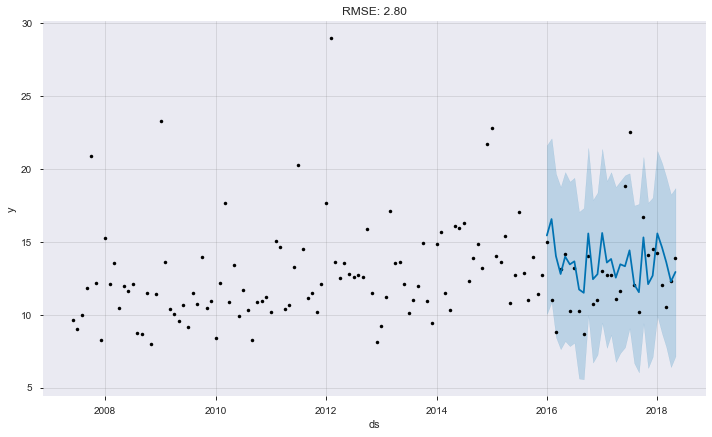

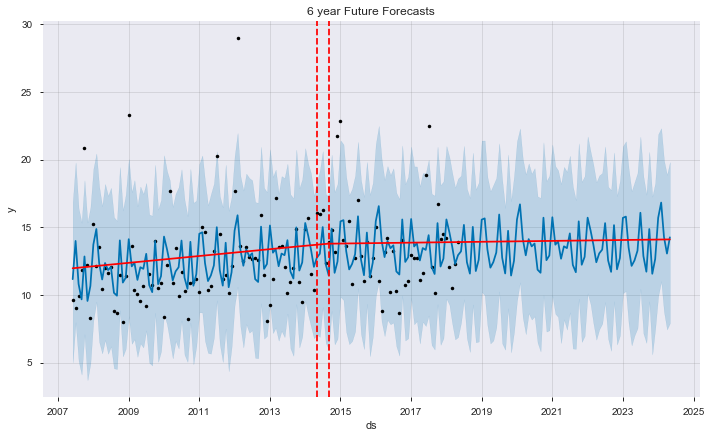

In [165]:
fit_plot_prophet(plywood_df,'plywood_interp')

### Plywood fit

Model seems to have fit the weird seasonality of plywood but has difficulty predicting the strength of the large spikes. Overall there's a lot of uncertainty going forward for plywood predictions but there is the clear upward trend...

# Summary

The prophet models might be pretty useful for steel, rebar, and concrete, but less trustworthy for plywood and glass.

But I'm not sure the model is any more useful for those 3 commodities than the recommendations we arrived at before purely from the monthly aggregate box plots. The model sees the same seasonalities and helps a little by adding trends and recognition of changepoints within those trends. 